### CS512 - Segmentation and classification of skin lesions
### Contains:
#### 1. Custom CNN model
#### 2. CNN + InceptionResnet (RMSprop)
#### 3. CNN + InceptionResnet (SGD)
#### 4. InceptionV3 (Frozen Weights)
#### 5. DenseNet121


#### --------------------------------------
#### --------------------------------------
### Authors:
#### Sourav Yadav - A20450418
#### Akshay R - A20442409

In [3]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# keras libraries
import keras

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import ReLU
from keras.layers import Add
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras import Input

# sklearn libraries
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# to make the results are reproducible
import torch
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [4]:
print(os.listdir("/Users/akshayrajeev/Documents/Deep Learning/Project/Data/skin-cancer-mnist-ham10000 (1) copy"))

['.DS_Store', 'HAM10000_images_part_1', 'HAM10000_images_part_2']


#### Functions to plot Confusion Matrix

In [5]:
def plot_confusion_matrix(cm, title, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")
    fig.colorbar(im, ax=ax)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = ax.text(j, i, cm[i, j],
                 ha="center",
                 va="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylim(len(classes)-0.5, -0.5)
    ax.set_title(title)
    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.show()
    
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    all_labels = np.unique(df_train.dx).tolist()
    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        __, c_ax = plt.subplots()
        c_ax.plot(fpr, tpr, 'r',label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.legend()
        c_ax.plot(fpr, fpr, '-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
    
def computeCM(model, x_features, x_labels, title, x_df):
    
    # Predict the values from the features dataset
    Y_pred = model.predict(x_features)
    
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    
    # Convert actual labels to one hot vectors
    Y_true = np.argmax(x_labels,axis = 1) 
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, title, classes = range(7))
    
    # Print the classification report
    print('\nClassification Report\n')
    target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    print(classification_report(x_df['cell_type_idx'], Y_pred_classes, target_names=target_names))
    
    # Print the roc curves and return the multiclass ROC score
    return (multiclass_roc_auc_score(x_df['cell_type_idx'], Y_pred_classes))

def computeCMNormalized(x, x_features, x_labels, title, x_df):
    
    # Predict the values from the features dataset
    Y_pred = x.predict(x_features)
    
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    
    # Convert actual labels to one hot vectors
    Y_true = np.argmax(x_labels,axis = 1) 
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    confusion_mtx_norm = np.round(confusion_mtx/confusion_mtx.astype(np.float).sum(axis=0), 2)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx_norm, title, classes = range(7))

#### Function to calculate test Performance

In [6]:
def calcTestPerformance(model):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    loss_v, accuracy_v = model.evaluate(x_val, y_val, verbose=1)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

#### Function to plot Loss and Accuracy values vs Epochs

In [7]:
def plotTrend(history, type_):
    if(type_ == 'Loss'):
        plt.plot(history.history['loss'], color = 'b', label = "Training Loss")
        plt.plot(history.history['val_loss'], color = 'r', label = "Validation Loss")
        plt.title('Loss vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        legend = plt.legend(loc='best', shadow = True)
        plt.show()
    else:
        plt.plot(history.history['accuracy'], color = 'b', label = "Training Accuracy")
        plt.plot(history.history['val_accuracy'], color = 'r', label = "Validation Accuracy")
        plt.title('Accuracy vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        legend = plt.legend(loc='best', shadow = True)
        plt.show()     

### Step 1. Data analysis and preprocessing

In [8]:
data_dir = '/Users/akshayrajeev/Documents/Deep Learning/Project/Data/skin-cancer-mnist-ham10000 (1) copy'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
len(imageid_path_dict)

0

#### This function is used to compute the mean and standard deviation on the whole dataset, will use for inputs normalization

In [9]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 75, 100
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

#### Add three columns to the original DataFrame, path (image path), cell_type (the whole name),cell_type_idx (the corresponding index of cell type, as the image label )

In [16]:
df_original = pd.read_csv(os.path.join('HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes


In [17]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,0,1,1
1,HAM_0000003,1,1,1,1,1,1,0,1,1
2,HAM_0000004,1,1,1,1,1,1,0,1,1
3,HAM_0000007,1,1,1,1,1,1,0,1,1
4,HAM_0000008,1,1,1,1,1,1,0,1,1


In [18]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)


In [12]:
print(df_original['duplicates'].value_counts())

# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64


(5514, 11)

In [13]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
Y = df_undup['cell_type_idx']
_, df_TEST = train_test_split(df_undup, test_size=0.5, random_state=20449302, stratify=Y)

y = df_TEST['cell_type_idx']
df_val, df_test = train_test_split(df_TEST, test_size=0.5, random_state=20449302, stratify=y)

print(df_val.shape, df_test.shape)

(1378, 11) (1379, 11)


In [14]:
df_val['cell_type_idx'].value_counts()

4    1103
2     110
6      57
1      44
0      38
5      16
3      10
Name: cell_type_idx, dtype: int64

In [15]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.

def get_val_rows(x):
    
    # create a list of all the lesion_id's in the val set
    val_list  = list(df_val['image_id'])
    
    # create a list of all the lesion_id's in the test set
    test_list = list(df_test['image_id'])
    
    if str(x) in val_list:
        return 'val'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'

# identify train, val and test rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val_or_test'] = df_original['image_id']

# apply the function to this new column
df_original['train_or_val_or_test'] = df_original['train_or_val_or_test'].apply(get_val_rows)

# filter out train rows
df_train = df_original[df_original['train_or_val_or_test'] == 'train']
print(len(df_train))
print(len(df_val))
print(len(df_test))

7258
1378
1379


In [16]:
df_train['cell_type_idx'].value_counts()

4    4498
6     998
2     879
1     427
0     251
5     110
3      95
Name: cell_type_idx, dtype: int64

In [17]:
0.5/df_train['cell_type_idx'].value_counts(normalize = True)

4     0.806803
6     3.636273
2     4.128555
1     8.498829
0    14.458167
5    32.990909
3    38.200000
Name: cell_type_idx, dtype: float64

In [18]:
df_train['cell_type'].value_counts()

Melanocytic nevi                  4498
dermatofibroma                     998
Benign keratosis-like lesions      879
Basal cell carcinoma               427
Actinic keratoses                  251
Vascular lesions                   110
Dermatofibroma                      95
Name: cell_type, dtype: int64

#### From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.

In [19]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5] # Inverse of the value proportion, expect for the type - Melanocytic nevi  
for i in range(7): 
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

dermatofibroma                    4990
Dermatofibroma                    4750
Melanocytic nevi                  4498
Vascular lesions                  4400
Benign keratosis-like lesions     4395
Basal cell carcinoma              4270
Actinic keratoses                 3765
Name: cell_type, dtype: int64

In [20]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [22]:
df_train['image'] = df_train['path'].map(lambda x:np.asarray(Image.open(x).resize((100,75))))
df_val['image'] = df_val['path'].map(lambda x:np.asarray(Image.open(x).resize((100,75))))
df_test['image'] = df_test['path'].map(lambda x:np.asarray(Image.open(x).resize((100,75))))

In [23]:
df_train['image'].map(lambda x : x.shape).value_counts()

(75, 100, 3)    31068
Name: image, dtype: int64

In [25]:
x_train = np.asarray(df_train['image'].tolist())
x_val   = np.asarray(df_val['image'].tolist())
x_test  = np.asarray(df_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std  = np.std(x_train)

x_train = (x_train - x_train_mean) / x_train_std
x_val   = (x_val - x_train_mean) / x_train_std
x_test  = (x_test - x_train_mean) / x_train_std 

# Label Encoding
y_train = to_categorical(df_train['cell_type_idx'], num_classes = 7)
y_val   = to_categorical(df_val['cell_type_idx'], num_classes = 7)
y_test  = to_categorical(df_test['cell_type_idx'], num_classes = 7)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test  = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_val   = x_val.reshape(x_val.shape[0], *(75, 100, 3))

In [26]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range     = 40,
    width_shift_range  = 0.2,
    height_shift_range = 0.2,
    shear_range        = 0.2,
    zoom_range         = 0.2,
    horizontal_flip    = True,
    fill_mode          = 'nearest'
)

# val_datagen  = ImageDataGenerator(rescale = 1./255)
# test_datagen = ImageDataGenerator(rescale = 1./255)

In [348]:
batch_size = 256#128

## training the model with the fully connected layer in conv_base is frozen
train_generator = train_datagen.flow(x_train, y_train, batch_size  = batch_size)
# val_generator = val_datagen.flow(x_val, y_val, batch_size  = batch_size)
# test_generator = test_datagen.flow(x_test, y_test, batch_size = batch_size)

### Model 0 - Trial Model

In [28]:
def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size: int = 3):
    #inception block
    tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
    
    print(tower_1.shape,  tower_2.shape, tower_3.shape)
    y = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    y = MaxPooling2D((3,3), strides=(2,2), padding='same')(y)
    y = Conv2D(128, 1, padding = 'same', activation = 'relu')(y)
    print(y.shape)
    if downsample:
        x = Conv2D(kernel_size=1, strides=2, filters=filters, padding="same")(x)
    print(x.shape, y.shape)
    out = Add()([x, y])
    out = relu_bn(out)
    
    return out

In [29]:
input_layer = Input(shape = (75, 100, 3))

#model1: block1
block1_Conv1 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input_layer)
block1_MPool1 = layers.MaxPooling2D(2)(block1_Conv1)
block1_Bn1 =    BatchNormalization()(block1_MPool1)

block1_Conv2 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(block1_Bn1)
block1_MPool2 = layers.MaxPooling2D(2)(block1_Conv2)
block1_Bn2 =    BatchNormalization()(block1_MPool2)

block1_Conv3 =  layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(block1_Bn1)
block1_MPool3 = layers.MaxPooling2D(2)(block1_Conv2)
block1_Bn3 =    BatchNormalization()(block1_MPool2)

block1_Conv4 =  layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(block1_Bn1)
block1_MPool4 = layers.MaxPooling2D(2)(block1_Conv2)
block1_Bn4 =    BatchNormalization()(block1_MPool2)

#residual block + inception block
output_residual = residual_block(block1_Bn2, downsample=(True), filters=128)
output_residual = residual_block(output_residual, downsample=(True), filters=128)
output_residual = residual_block(output_residual, downsample=(True), filters=128)

#dense block
dense1_flt =    layers.Flatten()(output_residual)
dense1_dense1 = layers.Dense(256, activation = 'relu')(dense1_flt)
dense1_bn1 = BatchNormalization()(dense1_dense1)
dense1_dp2 =    Dropout(0.5)(dense1_bn1)

output_layer = layers.Dense(7,activation = 'softmax')(dense1_dp2)

model1 = Model(inputs = input_layer, outputs = output_layer)
model1.summary()

(None, 18, 25, 64) (None, 18, 25, 64) (None, 18, 25, 64)
(None, 9, 13, 128)
(None, 9, 13, 128) (None, 9, 13, 128)
(None, 9, 13, 64) (None, 9, 13, 64) (None, 9, 13, 64)
(None, 5, 7, 128)
(None, 5, 7, 128) (None, 5, 7, 128)
(None, 5, 7, 64) (None, 5, 7, 64) (None, 5, 7, 64)
(None, 3, 4, 128)
(None, 3, 4, 128) (None, 3, 4, 128)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 100, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 37, 50, 32)   0        

In [76]:
#Compile the model
model1.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9) , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=2e-5)

In [31]:
epochs = 40
history0 = model1.fit_generator(train_generator
                                    , steps_per_epoch = x_train.shape[0]//batch_size 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//batch_size
                                    , callbacks=[reduce_lr]
                                   )

Epoch 1/40


/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


242/242 [==============================] - 259s 1s/step - loss: 1.9001 - accuracy: 0.4001 - val_loss: 0.6720 - val_accuracy: 0.7794
Epoch 2/40
242/242 [==============================] - 227s 939ms/step - loss: 1.3712 - accuracy: 0.5321 - val_loss: 0.5388 - val_accuracy: 0.8135
Epoch 3/40
242/242 [==============================] - 226s 935ms/step - loss: 1.1598 - accuracy: 0.5852 - val_loss: 0.7380 - val_accuracy: 0.7620
Epoch 4/40
242/242 [==============================] - 223s 921ms/step - loss: 1.0128 - accuracy: 0.6338 - val_loss: 0.7199 - val_accuracy: 0.7569
Epoch 5/40
242/242 [==============================] - 223s 922ms/step - loss: 0.8960 - accuracy: 0.6709 - val_loss: 0.6499 - val_accuracy: 0.7787
Epoch 6/40
242/242 [==============================] - 221s 914ms/step - loss: 0.8173 - accuracy: 0.6964 - val_loss: 0.7045 - val_accuracy: 0.7620
Epoch 7/40
242/242 [==============================] - 221s 915ms/step - loss: 0.7489 - accuracy: 0.7199 - val_loss: 0.5778 - val_accuracy:

In [32]:
model1.save("inception1_resnet3_mean_std_norm.h5")

#### Test Performance

In [68]:
calcTestPerformance(model1)

1379/1379 [==============================] - 3s 2ms/step
Validation: accuracy = 0.822335  ;  loss_v = 0.679343
Test: accuracy = 0.822335  ;  loss = 0.679343


#### Model Loss and Accuracy

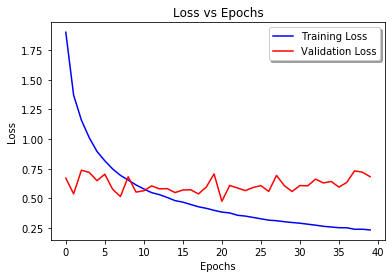

In [71]:
plotTrend(history0, "Loss")

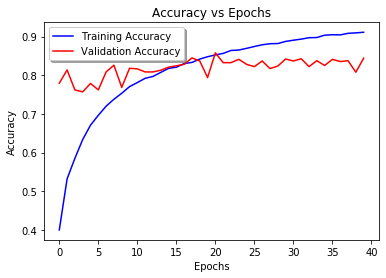

In [72]:
plotTrend(history0, " ")

#### Assessing model Classifier Performance


Classification Report

              precision    recall  f1-score   support

       akiec       0.36      0.11      0.16        38
         bcc       0.52      0.66      0.58        44
         bkl       0.52      0.66      0.58       110
          df       0.44      0.40      0.42        10
         mel       0.96      0.93      0.94      1103
          nv       0.92      0.69      0.79        16
        vasc       0.33      0.49      0.40        57

    accuracy                           0.85      1378
   macro avg       0.58      0.56      0.55      1378
weighted avg       0.87      0.85      0.85      1378

The multiclass ROC-AUC score  0.829134819984468


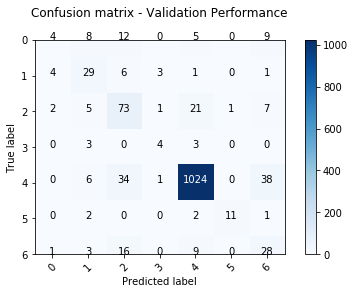

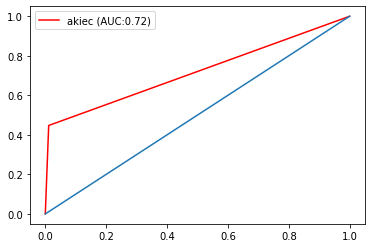

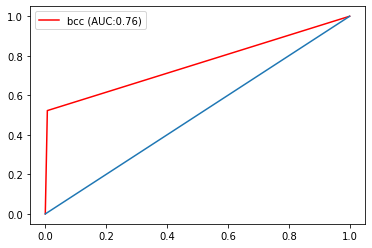

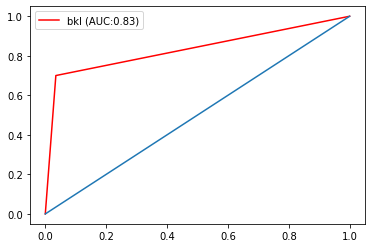

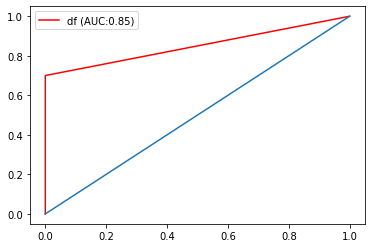

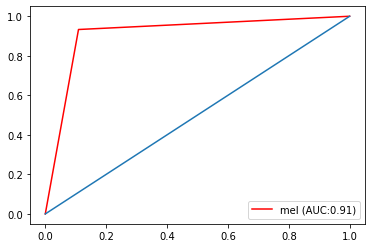

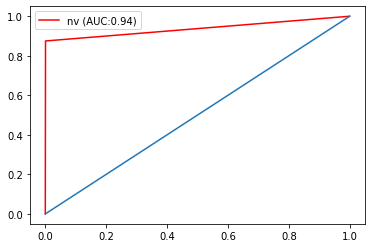

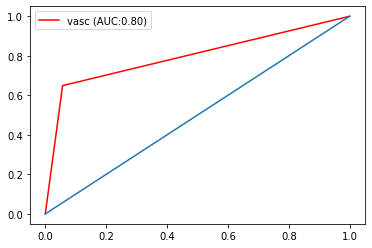

In [182]:
# Confusion Matrix on validation
print('The multiclass ROC-AUC score ',computeCM(model1, x_val, y_val, 'Confusion matrix - Validation Performance', df_val))


Classification Report

              precision    recall  f1-score   support

       akiec       0.62      0.34      0.44        38
         bcc       0.55      0.53      0.54        43
         bkl       0.50      0.65      0.56       110
          df       0.25      0.30      0.27        10
         mel       0.96      0.91      0.93      1104
          nv       0.88      0.88      0.88        16
        vasc       0.30      0.52      0.38        58

    accuracy                           0.84      1379
   macro avg       0.58      0.59      0.57      1379
weighted avg       0.86      0.84      0.85      1379

The multiclass ROC-AUC score  0.7730175550224612


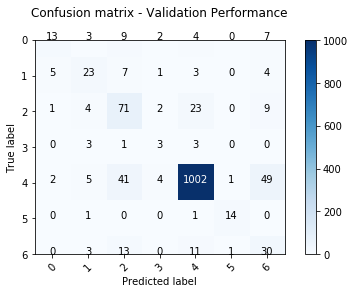

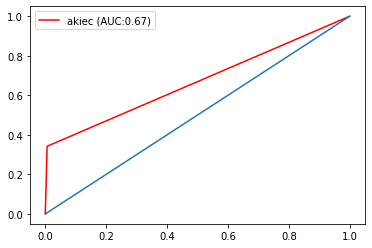

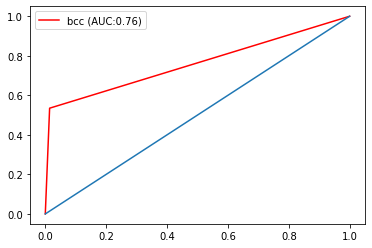

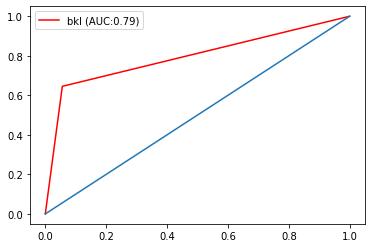

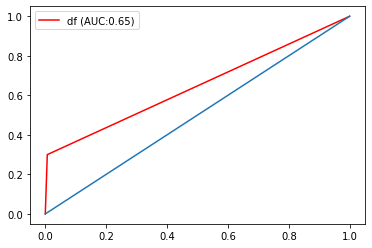

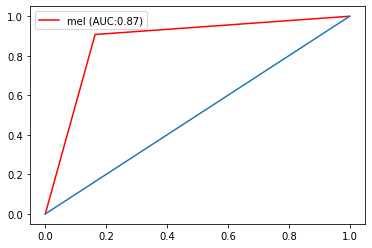

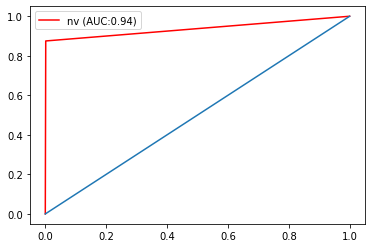

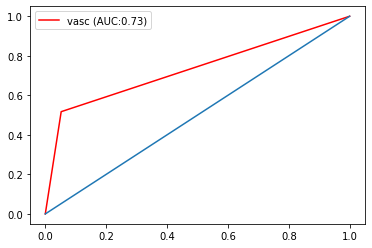

In [190]:
# Confusion Matrix on test
print('The multiclass ROC-AUC score ',computeCM(model1, x_test, y_test, 'Confusion matrix - Validation Performance', df_test))

### Model 2 - CNN + InceptionResnet (RMSprop)

In [97]:
input_layer = Input(shape = (75, 100, 3))

#model0: block1
block1_Conv1 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input_layer)
block1_Conv2 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(block1_Conv1)
block1_MPool2 = layers.MaxPooling2D(2)(block1_Conv2)
block1_Bn1 =    BatchNormalization()(block1_MPool2)
block1_dp1 =    Dropout(0.5)(block1_Bn1)

block1_Conv3 =  layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(block1_dp1)
block1_Conv4 =  layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(block1_Conv3)
block1_MPool4 = layers.MaxPooling2D(2)(block1_Conv4)
block1_Bn2 =    BatchNormalization()(block1_MPool4)
block1_dp2 =    Dropout(0.5)(block1_Bn2)

#residual block + inception block
output_residual = residual_block(block1_Bn2, downsample=(True), filters=128)
output_residual = residual_block(output_residual, downsample=(True), filters=128)

#dense block
dense1_flt =    layers.Flatten()(output_residual)
dense1_dense1 = layers.Dense(256, activation = 'relu')(dense1_flt)
dense1_bn1 = BatchNormalization()(dense1_dense1)
dense1_dp3 =    Dropout(0.5)(dense1_bn1)

output_layer = layers.Dense(7,activation = 'softmax')(dense1_dp3)

model1b = Model(inputs = input_layer, outputs = output_layer)
model1b.summary()

(None, 18, 25, 64) (None, 18, 25, 64) (None, 18, 25, 64)
(None, 9, 13, 128)
(None, 9, 13, 128) (None, 9, 13, 128)
(None, 9, 13, 64) (None, 9, 13, 64) (None, 9, 13, 64)
(None, 5, 7, 128)
(None, 5, 7, 128) (None, 5, 7, 128)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv2d_138 (Conv2D)             (None, 75, 100, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 75, 100, 32)  9248        conv2d_138[0][0]                 
____________________________________________________________________

In [98]:
#Compile the model
model1b.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, decay = 0.001/epochs) , loss = "categorical_crossentropy", metrics=["accuracy"])

In [99]:
epochs = 30
history0_b = model1b.fit_generator(train_generator
                                    , steps_per_epoch = x_train.shape[0]//batch_size 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//batch_size
                                   )

Epoch 1/30


/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


242/242 [==============================] - 429s 2s/step - loss: 1.4298 - accuracy: 0.4978 - val_loss: 1.2666 - val_accuracy: 0.6176
Epoch 2/30
242/242 [==============================] - 440s 2s/step - loss: 0.9553 - accuracy: 0.6389 - val_loss: 0.5425 - val_accuracy: 0.8106
Epoch 3/30
242/242 [==============================] - 429s 2s/step - loss: 0.7863 - accuracy: 0.7034 - val_loss: 0.5777 - val_accuracy: 0.8353
Epoch 4/30
242/242 [==============================] - 418s 2s/step - loss: 0.6810 - accuracy: 0.7417 - val_loss: 0.6389 - val_accuracy: 0.8164
Epoch 5/30
242/242 [==============================] - 415s 2s/step - loss: 0.6139 - accuracy: 0.7660 - val_loss: 0.5846 - val_accuracy: 0.7975
Epoch 6/30
242/242 [==============================] - 423s 2s/step - loss: 0.5578 - accuracy: 0.7884 - val_loss: 0.5507 - val_accuracy: 0.8244
Epoch 7/30
242/242 [==============================] - 425s 2s/step - loss: 0.5091 - accuracy: 0.8064 - val_loss: 0.4526 - val_accuracy: 0.8541
Epoch 8/30

In [100]:
model1b.save("inception1_resnet3_mean_std_norm_1b.h5")

#### Test performance

In [330]:
calcTestPerformance(model1b)

1378/1378 [==============================] - 5s 4ms/step
Validation: accuracy = 0.841800  ;  loss_v = 0.675796
Test: accuracy = 0.836113  ;  loss = 0.586187


#### Model loss and accuracy

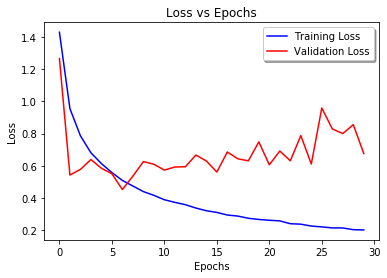

In [102]:
plotTrend(history0_b, "Loss")

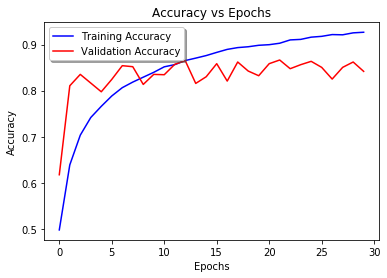

In [103]:
plotTrend(history0_b, " ")

#### Assessing Model Classifier performance

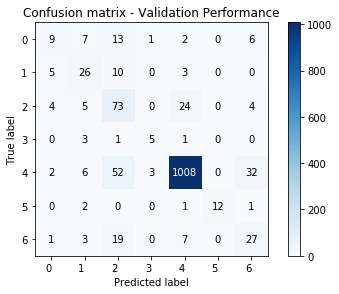


Classification Report

              precision    recall  f1-score   support

       akiec       0.43      0.24      0.31        38
         bcc       0.50      0.59      0.54        44
         bkl       0.43      0.66      0.53       110
          df       0.56      0.50      0.53        10
         mel       0.96      0.91      0.94      1103
          nv       1.00      0.75      0.86        16
        vasc       0.39      0.47      0.43        57

    accuracy                           0.84      1378
   macro avg       0.61      0.59      0.59      1378
weighted avg       0.87      0.84      0.85      1378

The multiclass ROC-AUC score  0.7751371088350884


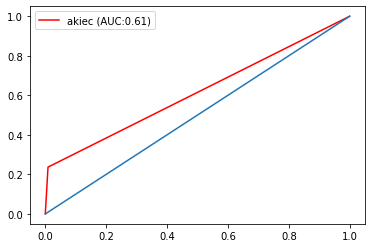

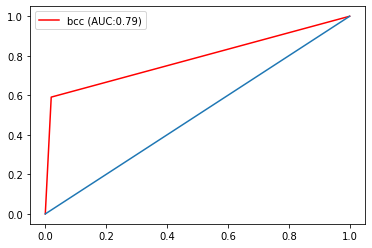

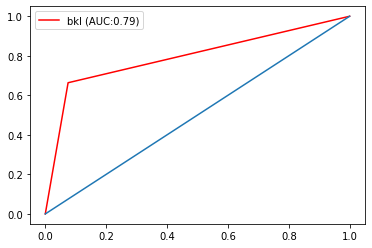

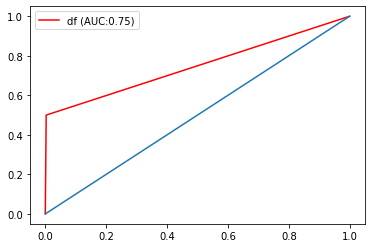

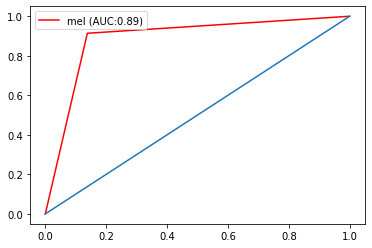

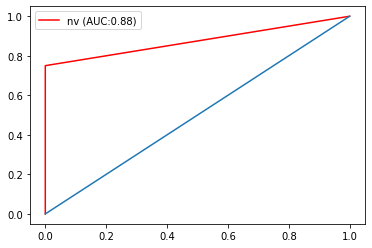

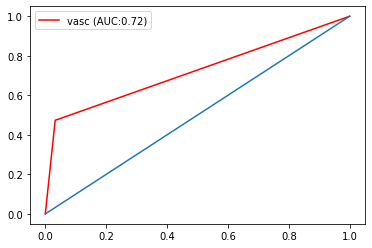

In [299]:
# Confusion Matrix on validation
print('The multiclass ROC-AUC score ',computeCM(model1b, x_val, y_val, 'Confusion matrix - Validation Performance', df_val))

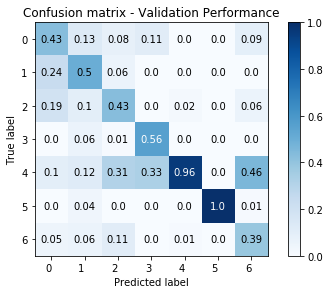

In [321]:
# Normalized confusion matrix - Validation
computeCMNormalized(model1b, x_val, y_val, 'Confusion matrix - Validation Performance', df_val)

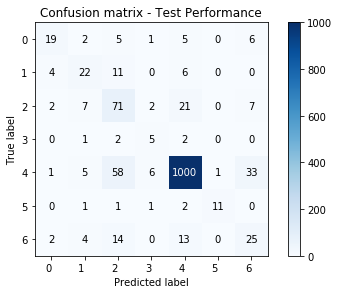


Classification Report

              precision    recall  f1-score   support

       akiec       0.68      0.50      0.58        38
         bcc       0.52      0.51      0.52        43
         bkl       0.44      0.65      0.52       110
          df       0.33      0.50      0.40        10
         mel       0.95      0.91      0.93      1104
          nv       0.92      0.69      0.79        16
        vasc       0.35      0.43      0.39        58

    accuracy                           0.84      1379
   macro avg       0.60      0.60      0.59      1379
weighted avg       0.86      0.84      0.85      1379

The multiclass ROC-AUC score  0.7762128828014353


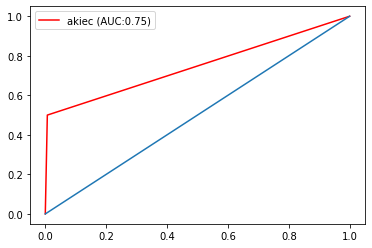

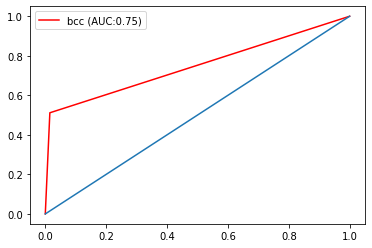

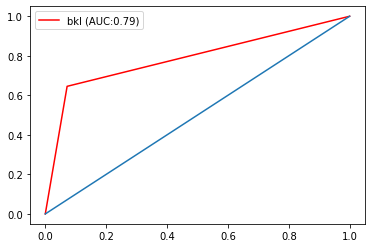

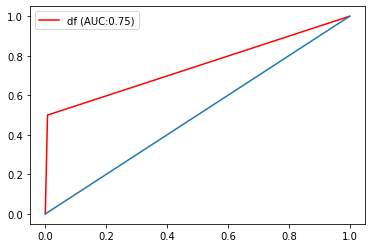

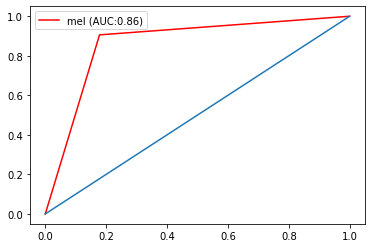

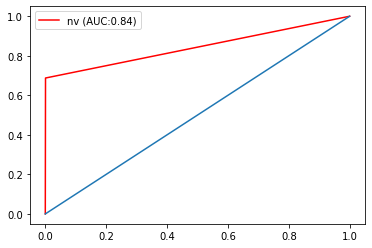

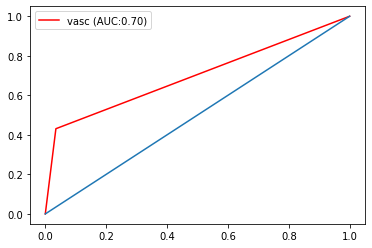

In [312]:
# Confusion Matrix on test
print('The multiclass ROC-AUC score ',computeCM(model1b, x_test, y_test, 'Confusion matrix - Test Performance', df_test))

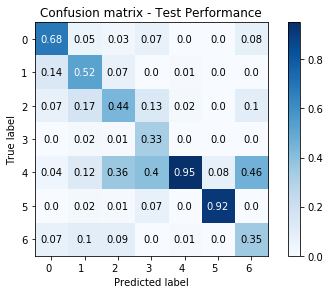

In [322]:
# Normalized Confusion Matrix - test
computeCMNormalized(model1b, x_test, y_test, 'Confusion matrix - Test Performance', df_test)

### Model 3 - CNN + InceptionResnet (SGD)

In [360]:
input_layer = Input(shape = (75, 100, 3))

#model0: block1
block1_Conv1 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input_layer)
block1_Conv2 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(block1_Conv1)
block1_MPool2 = layers.MaxPooling2D(2)(block1_Conv2)
block1_Bn1 =    BatchNormalization()(block1_MPool2)
block1_dp1 =    Dropout(0.5)(block1_Bn1)

block1_Conv3 =  layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(block1_dp1)
block1_Conv4 =  layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(block1_Conv3)
block1_MPool4 = layers.MaxPooling2D(2)(block1_Conv4)
block1_Bn2 =    BatchNormalization()(block1_MPool4)
block1_dp2 =    Dropout(0.5)(block1_Bn2)

#residual block + inception block
output_residual = residual_block(block1_Bn2, downsample=(True), filters=128)
output_residual = residual_block(output_residual, downsample=(True), filters=128)

#dense block
dense1_flt =    layers.Flatten()(output_residual)
dense1_dense1 = layers.Dense(256, activation = 'relu')(dense1_flt)
dense1_bn1 = BatchNormalization()(dense1_dense1)
dense1_dp3 =    Dropout(0.5)(dense1_bn1)

output_layer = layers.Dense(7,activation = 'softmax')(dense1_dp3)

model1c = Model(inputs = input_layer, outputs = output_layer)
model1c.summary()

(None, 18, 25, 64) (None, 18, 25, 64) (None, 18, 25, 64)
(None, 9, 13, 128)
(None, 9, 13, 128) (None, 9, 13, 128)
(None, 9, 13, 64) (None, 9, 13, 64) (None, 9, 13, 64)
(None, 5, 7, 128)
(None, 5, 7, 128) (None, 5, 7, 128)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 75, 100, 32)  896         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 75, 100, 32)  9248        conv2d_192[0][0]                 
____________________________________________________________________

In [361]:
sgd_opt = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True) 

In [362]:
model1c.compile(optimizer = sgd_opt , loss = "categorical_crossentropy", metrics=["accuracy"])

In [363]:
epochs = 25
history0_c = model1c.fit_generator(train_generator
                                    , steps_per_epoch = x_train.shape[0]//batch_size 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//batch_size
                                   )

model1c.save("inception1_resnet3_mean_std_norm_1c.h5")

Epoch 1/25


/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


121/121 [==============================] - 441s 4s/step - loss: 2.2865 - accuracy: 0.3001 - val_loss: 3.6109 - val_accuracy: 0.0073
Epoch 2/25
121/121 [==============================] - 446s 4s/step - loss: 1.6905 - accuracy: 0.4214 - val_loss: 3.3359 - val_accuracy: 0.0450
Epoch 3/25
121/121 [==============================] - 439s 4s/step - loss: 1.4850 - accuracy: 0.4723 - val_loss: 2.4203 - val_accuracy: 0.1350
Epoch 4/25
121/121 [==============================] - 449s 4s/step - loss: 1.3714 - accuracy: 0.4989 - val_loss: 1.7445 - val_accuracy: 0.3280
Epoch 5/25
121/121 [==============================] - 489s 4s/step - loss: 1.2853 - accuracy: 0.5264 - val_loss: 1.1820 - val_accuracy: 0.5733
Epoch 6/25
121/121 [==============================] - 500s 4s/step - loss: 1.2255 - accuracy: 0.5447 - val_loss: 0.9884 - val_accuracy: 0.6451
Epoch 7/25
121/121 [==============================] - 526s 4s/step - loss: 1.1930 - accuracy: 0.5556 - val_loss: 1.1044 - val_accuracy: 0.6067
Epoch 8/25

#### Test performance

In [364]:
calcTestPerformance(model1c)

1378/1378 [==============================] - 5s 4ms/step
Validation: accuracy = 0.745283  ;  loss_v = 0.684438
Test: accuracy = 0.738941  ;  loss = 0.728972


#### Model Loss and Accuracy

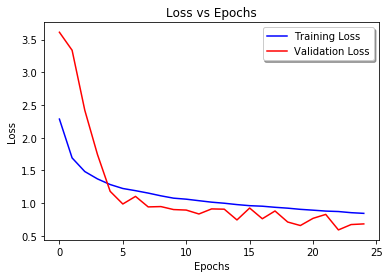

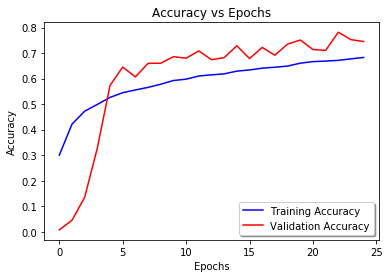

(None, None)

In [365]:
plotTrend(history0_c, "Loss"), plotTrend(history0_c, " ")

#### Assessing model classifier performance

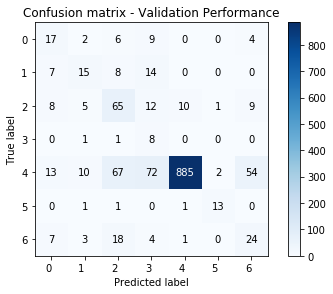


Classification Report

              precision    recall  f1-score   support

       akiec       0.33      0.45      0.38        38
         bcc       0.41      0.34      0.37        44
         bkl       0.39      0.59      0.47       110
          df       0.07      0.80      0.12        10
         mel       0.99      0.80      0.89      1103
          nv       0.81      0.81      0.81        16
        vasc       0.26      0.42      0.32        57

    accuracy                           0.75      1378
   macro avg       0.46      0.60      0.48      1378
weighted avg       0.86      0.75      0.79      1378

The multiclass ROC-AUC score  0.7796524127335068


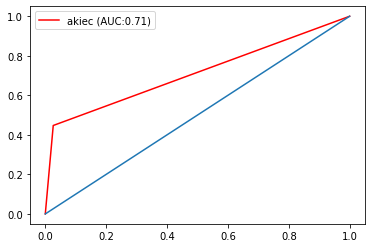

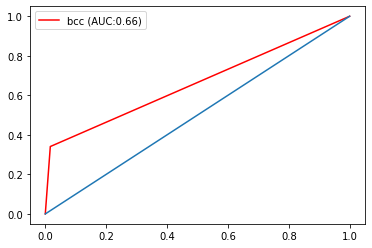

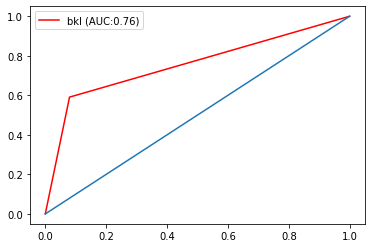

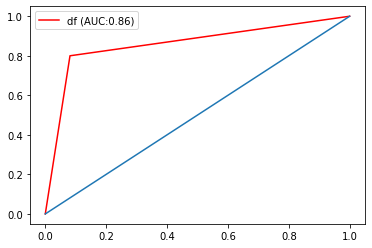

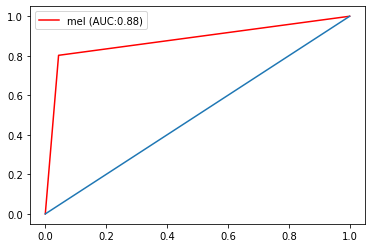

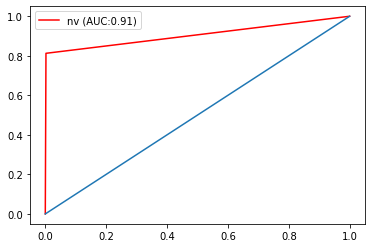

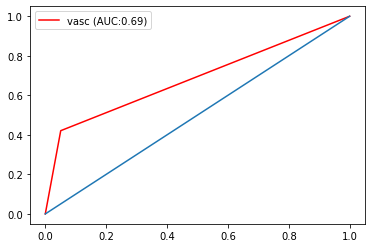

In [366]:
# Confusion Matrix on validation
print('The multiclass ROC-AUC score ',computeCM(model1c, x_val, y_val, 'Confusion matrix - Validation Performance', df_val))

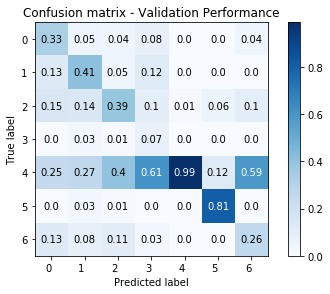

In [368]:
computeCMNormalized(model1c, x_val, y_val, 'Confusion matrix - Validation Performance', df_val)

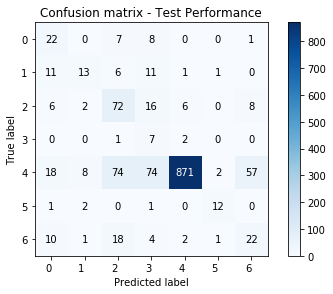


Classification Report

              precision    recall  f1-score   support

       akiec       0.32      0.58      0.42        38
         bcc       0.50      0.30      0.38        43
         bkl       0.40      0.65      0.50       110
          df       0.06      0.70      0.11        10
         mel       0.99      0.79      0.88      1104
          nv       0.75      0.75      0.75        16
        vasc       0.25      0.38      0.30        58

    accuracy                           0.74      1379
   macro avg       0.47      0.59      0.48      1379
weighted avg       0.87      0.74      0.79      1379

The multiclass ROC-AUC score  0.775024648089037


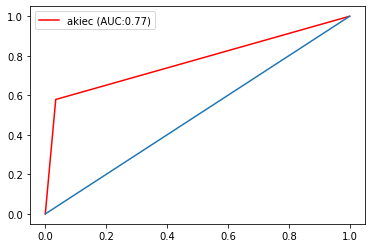

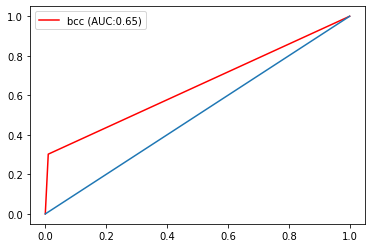

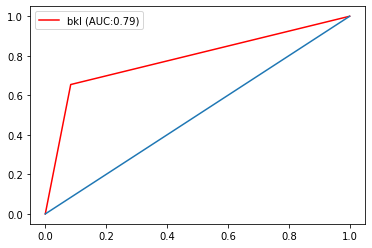

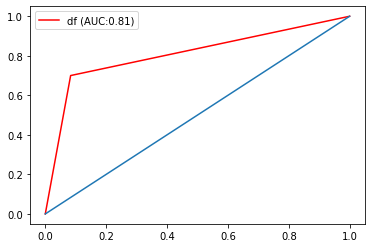

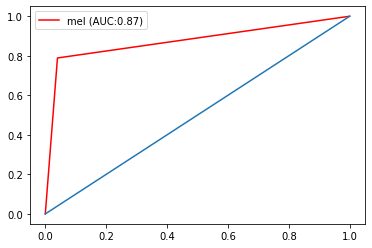

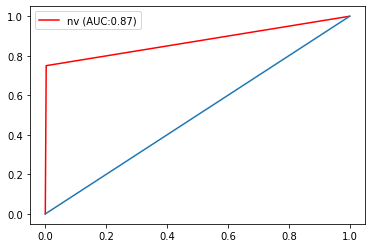

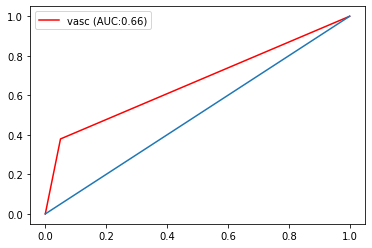

In [369]:
# Confusion Matrix on test
print('The multiclass ROC-AUC score ',computeCM(model1c, x_test, y_test, 'Confusion matrix - Test Performance', df_test))

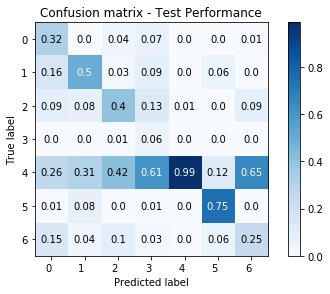

In [370]:
computeCMNormalized(model1c, x_test, y_test, 'Confusion matrix - Test Performance', df_test)

### Model 4 - InceptionV3 (Frozen Weights)

In [61]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

In [62]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(75, 100, 3))  # this assumes K.image_data_format() == 'channels_last'

In [63]:
incV3 = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [64]:
### Freezing the weights
incV3.trainable = False
incV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 37, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 37, 49, 32)   96          conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 37, 49, 32)   0           batch_normalization_9[0][0]      
_______________________________________________________________________________________

In [65]:
model2 = Sequential()
model2.add(incV3)
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(7, activation='softmax', name = 'output_layer'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_103 (Bat (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
output_layer (Dense)         (None, 7)                 7175      
Total params: 23,912,231
Trainable params: 2,107,399
Non-trainable params: 21,804,832
__________________________________

In [77]:
#Compile the model
model2.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9) , loss = "categorical_crossentropy", metrics=["accuracy"])

In [78]:
epochs = 40
history2 = model2.fit_ge nerator(train_generator
                                    , steps_per_epoch = x_train.shape[0]//batch_size 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//batch_size
                                    , callbacks=[reduce_lr]
                                   )

model2.save("inceptionV3_mean_std_norm.h5")

Epoch 1/40


/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


242/242 [==============================] - 131s 540ms/step - loss: 2.3665 - accuracy: 0.2498 - val_loss: 4.0246 - val_accuracy: 0.1488
Epoch 2/40
242/242 [==============================] - 125s 516ms/step - loss: 2.0196 - accuracy: 0.3233 - val_loss: 6.8529 - val_accuracy: 0.1372
Epoch 3/40
242/242 [==============================] - 123s 510ms/step - loss: 1.9192 - accuracy: 0.3458 - val_loss: 6.0756 - val_accuracy: 0.1597
Epoch 4/40
242/242 [==============================] - 127s 523ms/step - loss: 1.8439 - accuracy: 0.3624 - val_loss: 5.5522 - val_accuracy: 0.1800
Epoch 5/40
242/242 [==============================] - 121s 501ms/step - loss: 1.7806 - accuracy: 0.3745 - val_loss: 5.9259 - val_accuracy: 0.1408
Epoch 6/40
242/242 [==============================] - 115s 477ms/step - loss: 1.7714 - accuracy: 0.3764 - val_loss: 5.9586 - val_accuracy: 0.1350
Epoch 7/40
242/242 [==============================] - 115s 477ms/step - loss: 1.7311 - accuracy: 0.3866 - val_loss: 5.3509 - val_accura

#### Test Performance

In [331]:
calcTestPerformance(model2)

1378/1378 [==============================] - 6s 4ms/step
Validation: accuracy = 0.757620  ;  loss_v = 0.709212
Test: accuracy = 0.763597  ;  loss = 0.716735


#### Model Loss and Accuracy

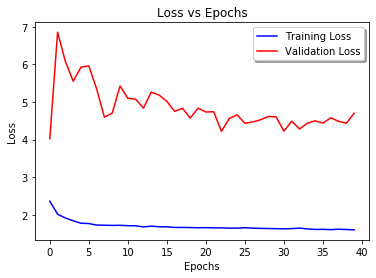

In [80]:
plotTrend(history2,'Loss')

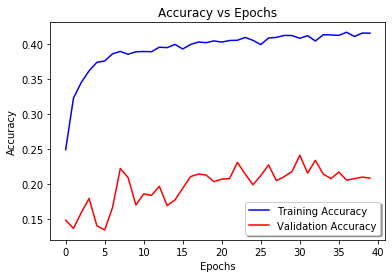

In [81]:
plotTrend(history2,' ')

#### Let's unfreeze the top layers and retrain the model

In [84]:
incV3.trainable = True
set_trainable = False

for layer in incV3.layers:
    if layer.name == 'conv2d_101':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [85]:
### Using the same model weights learnt in the previous iteration
#Compile the model
model2.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9) 
               , loss = "categorical_crossentropy"
               , metrics=["accuracy"])

epochs = 40
history2_unfrozen_conv2d_101 = model2.fit_generator(  train_generator
                                    , steps_per_epoch = x_train.shape[0]//batch_size 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//batch_size
                                    , callbacks=[reduce_lr]
                                   )

model2.save('inceptionV3_conv2d_101_unfrozen.h5')

Epoch 1/40


/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


242/242 [==============================] - 221s 912ms/step - loss: 1.4283 - accuracy: 0.4842 - val_loss: 1.1723 - val_accuracy: 0.6226
Epoch 2/40
242/242 [==============================] - 210s 867ms/step - loss: 1.2756 - accuracy: 0.5506 - val_loss: 0.9997 - val_accuracy: 0.6553
Epoch 3/40
242/242 [==============================] - 202s 834ms/step - loss: 1.1723 - accuracy: 0.5819 - val_loss: 0.9489 - val_accuracy: 0.6996
Epoch 4/40
242/242 [==============================] - 204s 842ms/step - loss: 1.0784 - accuracy: 0.6108 - val_loss: 0.8676 - val_accuracy: 0.7134
Epoch 5/40
242/242 [==============================] - 203s 838ms/step - loss: 1.0353 - accuracy: 0.6306 - val_loss: 0.8451 - val_accuracy: 0.7228
Epoch 6/40
242/242 [==============================] - 204s 842ms/step - loss: 0.9860 - accuracy: 0.6473 - val_loss: 0.7935 - val_accuracy: 0.7199
Epoch 7/40
242/242 [==============================] - 222s 916ms/step - loss: 0.9470 - accuracy: 0.6619 - val_loss: 0.9073 - val_accura

#### Test Performance

In [86]:
calcTestPerformance(model2)

1379/1379 [==============================] - 5s 4ms/step
Validation: accuracy = 0.763597  ;  loss_v = 0.716735
Test: accuracy = 0.763597  ;  loss = 0.716735


#### Model Loss and Accuracy

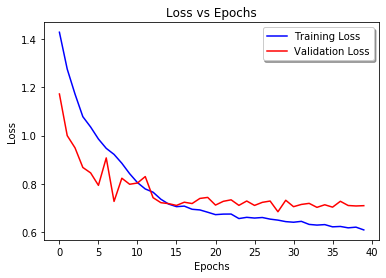

In [332]:
plotTrend(history2_unfrozen_conv2d_101,'Loss')

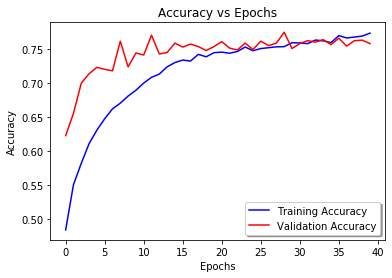

In [333]:
plotTrend(history2_unfrozen_conv2d_101,' ')

#### Assessing Model Classifier Performance

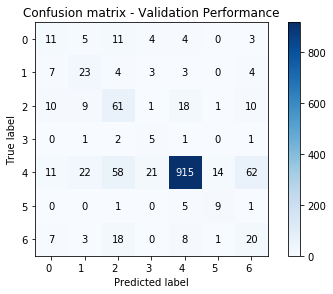


Classification Report

              precision    recall  f1-score   support

       akiec       0.24      0.29      0.26        38
         bcc       0.37      0.52      0.43        44
         bkl       0.39      0.55      0.46       110
          df       0.15      0.50      0.23        10
         mel       0.96      0.83      0.89      1103
          nv       0.36      0.56      0.44        16
        vasc       0.20      0.35      0.25        57

    accuracy                           0.76      1378
   macro avg       0.38      0.52      0.42      1378
weighted avg       0.83      0.76      0.79      1378

The multiclass ROC-AUC score  0.7316686308905991


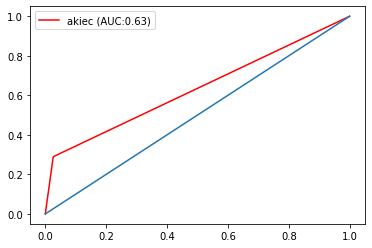

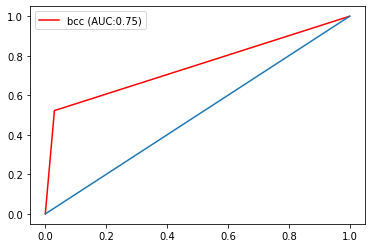

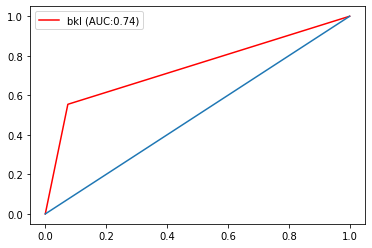

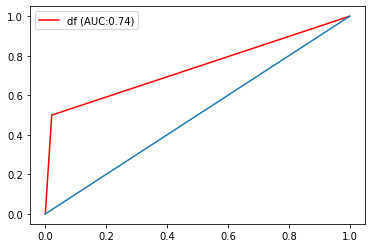

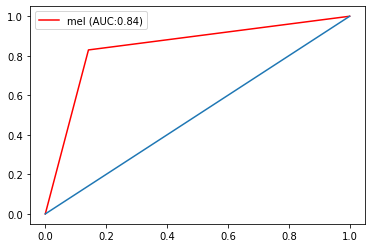

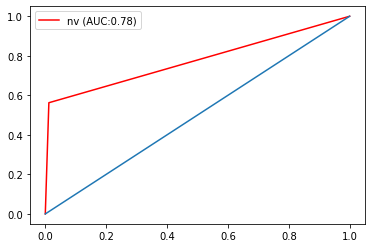

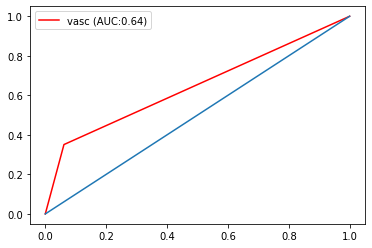

In [305]:
# Confusion Matrix on validation
print('The multiclass ROC-AUC score ',computeCM(model2, x_val, y_val, 'Confusion matrix - Validation Performance', df_val))

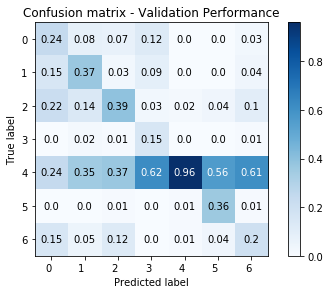

In [323]:
# Normalized Confusion Matrix - Validation
computeCMNormalized(model2, x_val, y_val, 'Confusion matrix - Validation Performance', df_val)

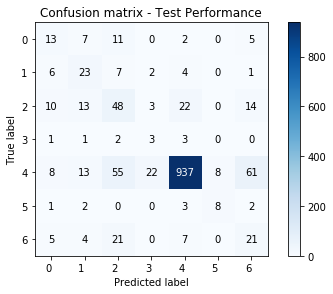


Classification Report

              precision    recall  f1-score   support

       akiec       0.30      0.34      0.32        38
         bcc       0.37      0.53      0.43        43
         bkl       0.33      0.44      0.38       110
          df       0.10      0.30      0.15        10
         mel       0.96      0.85      0.90      1104
          nv       0.50      0.50      0.50        16
        vasc       0.20      0.36      0.26        58

    accuracy                           0.76      1379
   macro avg       0.39      0.47      0.42      1379
weighted avg       0.83      0.76      0.79      1379

The multiclass ROC-AUC score  0.7112808733442756


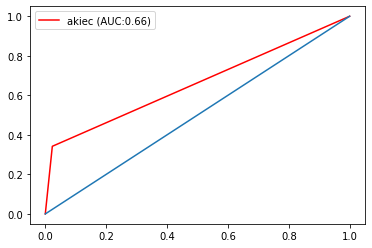

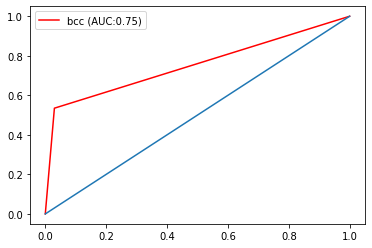

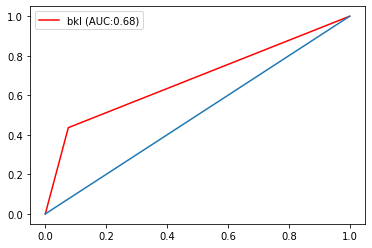

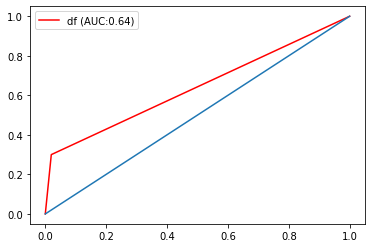

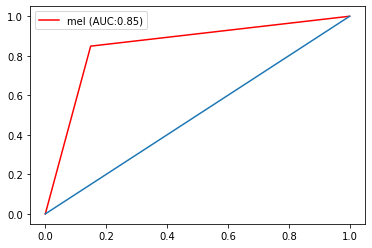

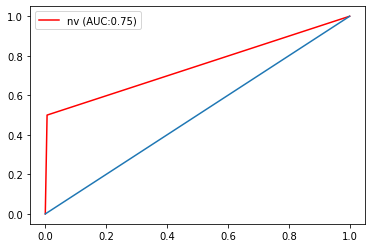

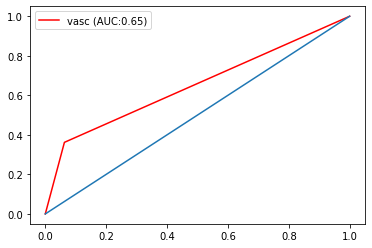

In [337]:
# Confusion Matrix on test
print('The multiclass ROC-AUC score ',computeCM(model2, x_test, y_test, 'Confusion matrix - Test Performance', df_test))

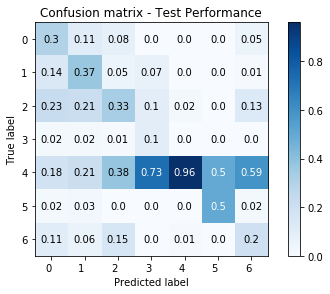

In [338]:
# Normalized Confusion Matrix - test
computeCMNormalized(model2, x_test, y_test, 'Confusion matrix - Test Performance', df_test)

### Model 4 - DenseNet121

In [108]:
from keras.applications.densenet import DenseNet121

In [109]:
denseNet1 = DenseNet121(include_top = False, weights='imagenet', input_tensor=input_tensor)

In [110]:
denseNet1.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 81, 106, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 38, 50, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 38, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [111]:
model3 = Sequential()
model3.add(denseNet1)
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(7, activation='softmax', name = 'output_layer'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 2, 3, 1024)        7037504   
_________________________________________________________________
flatten_5 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                393280    
_________________________________________________________________
batch_normalization_114 (Bat (None, 64)                256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 7)                 455       
Total params: 7,431,495
Trainable params: 7,347,719
Non-trainable params: 83,776
_______________________________________

In [112]:
denseNet2 = DenseNet121(include_top = True, weights='imagenet', input_tensor=input_tensor)
denseNet2.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 81, 106, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 38, 50, 64)   9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 38, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [113]:
#Compile the model
model3.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, decay = 0.001/epochs) 
                    , loss = "categorical_crossentropy"
               , metrics=["accuracy"])

epochs = 15
history3 = model3.fit_generator(  train_generator
                                    , steps_per_epoch = x_train.shape[0]//batch_size 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//batch_size
                                   )

model3.save('denseNet121_lr_decay.h5')

Epoch 1/15


/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/aravindsenthilkumar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


242/242 [==============================] - 1244s 5s/step - loss: 0.9570 - accuracy: 0.6654 - val_loss: 1.3211 - val_accuracy: 0.6821
Epoch 2/15
242/242 [==============================] - 1237s 5s/step - loss: 0.5453 - accuracy: 0.8049 - val_loss: 1.5023 - val_accuracy: 0.6060
Epoch 3/15
242/242 [==============================] - 1219s 5s/step - loss: 0.4200 - accuracy: 0.8498 - val_loss: 0.6691 - val_accuracy: 0.8200
Epoch 4/15
242/242 [==============================] - 1206s 5s/step - loss: 0.3458 - accuracy: 0.8784 - val_loss: 0.8611 - val_accuracy: 0.8004
Epoch 5/15
242/242 [==============================] - 1208s 5s/step - loss: 0.2952 - accuracy: 0.8937 - val_loss: 0.8701 - val_accuracy: 0.7859
Epoch 6/15
242/242 [==============================] - 1208s 5s/step - loss: 0.2614 - accuracy: 0.9087 - val_loss: 0.7237 - val_accuracy: 0.8229
Epoch 7/15
242/242 [==============================] - 1207s 5s/step - loss: 0.2297 - accuracy: 0.9193 - val_loss: 0.7631 - val_accuracy: 0.8164
Epo

#### Test Performance

In [334]:
calcTestPerformance(model3)

1378/1378 [==============================] - 15s 11ms/step
Validation: accuracy = 0.873730  ;  loss_v = 0.667968
Test: accuracy = 0.875997  ;  loss = 0.651252


#### Model Loss and Accuracy

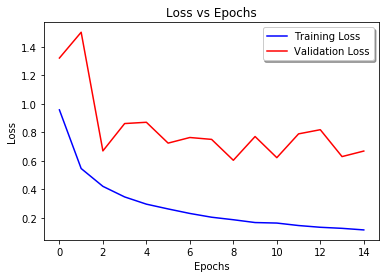

In [115]:
plotTrend(history3,'Loss')

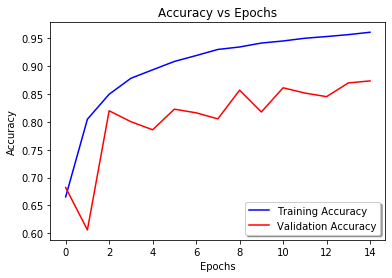

In [116]:
plotTrend(history3,' ')

#### Assessing Model Classifier Performance

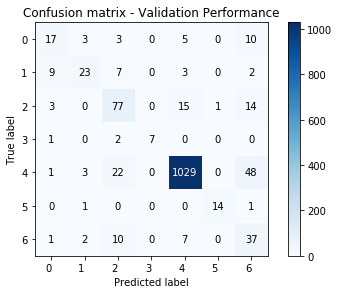


Classification Report

              precision    recall  f1-score   support

       akiec       0.53      0.45      0.49        38
         bcc       0.72      0.52      0.61        44
         bkl       0.64      0.70      0.67       110
          df       1.00      0.70      0.82        10
         mel       0.97      0.93      0.95      1103
          nv       0.93      0.88      0.90        16
        vasc       0.33      0.65      0.44        57

    accuracy                           0.87      1378
   macro avg       0.73      0.69      0.70      1378
weighted avg       0.90      0.87      0.88      1378

The multiclass ROC-AUC score  0.829134819984468


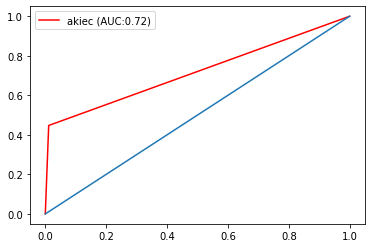

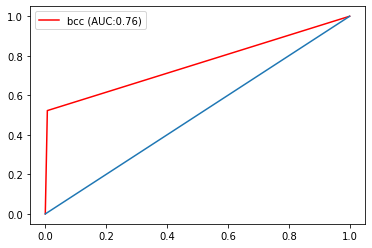

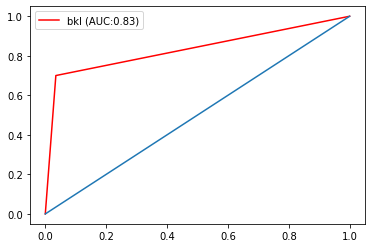

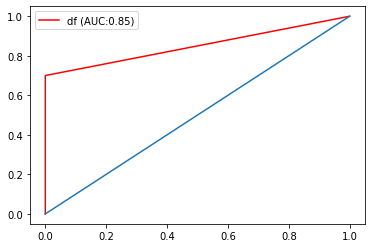

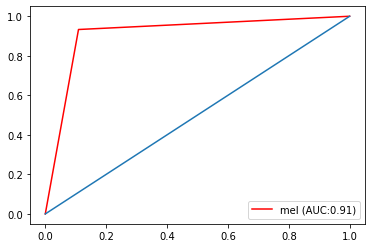

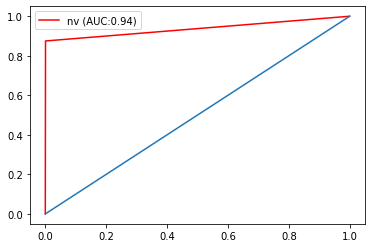

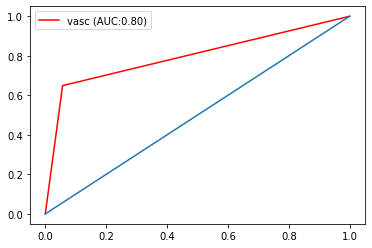

In [327]:
# Confusion Matrix on validation
print('The multiclass ROC-AUC score ',computeCM(model3, x_val, y_val, 'Confusion matrix - Validation Performance', df_val))

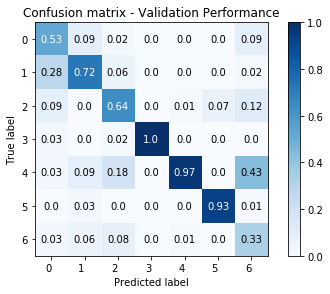

In [325]:
# Normalized Confusion matrix - Validation
computeCMNormalized(model3, x_val, y_val, 'Confusion matrix - Validation Performance', df_val)

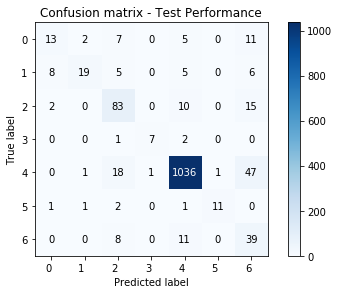


Classification Report

              precision    recall  f1-score   support

       akiec       0.54      0.34      0.42        38
         bcc       0.83      0.44      0.58        43
         bkl       0.67      0.75      0.71       110
          df       0.88      0.70      0.78        10
         mel       0.97      0.94      0.95      1104
          nv       0.92      0.69      0.79        16
        vasc       0.33      0.67      0.44        58

    accuracy                           0.88      1379
   macro avg       0.73      0.65      0.67      1379
weighted avg       0.90      0.88      0.88      1379

The multiclass ROC-AUC score  0.8077443816958431


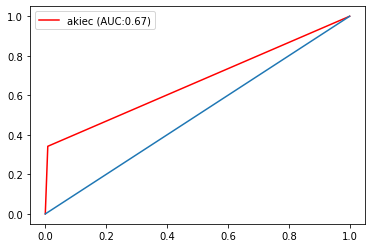

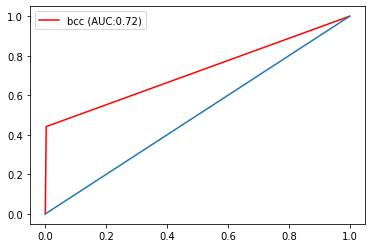

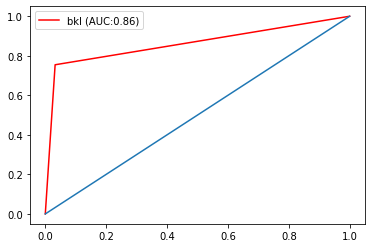

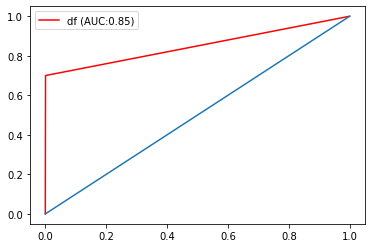

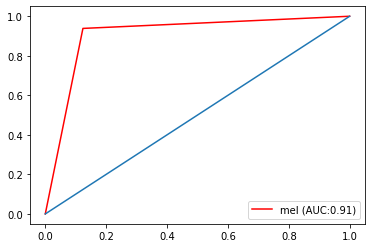

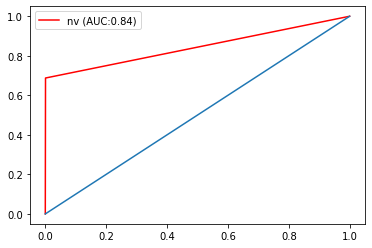

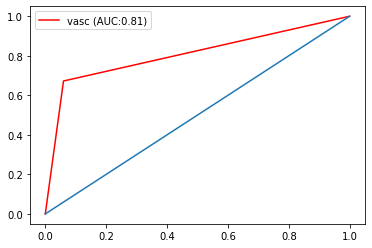

In [335]:
# Confusion Matrix on test
print('The multiclass ROC-AUC score ',computeCM(model3, x_test, y_test, 'Confusion matrix - Test Performance', df_test))

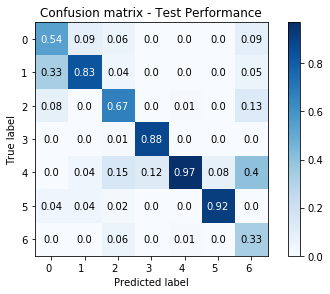

In [336]:
# Normalized Confusion Matrix - test
computeCMNormalized(model3, x_test, y_test, 'Confusion matrix - Test Performance', df_test)